# Geração de embeddings com skipGCN

In [1]:
# ==========================================================
# Skip-GCN (AF) — re-train with global seed and extract embeddings (h1)
# ==========================================================
import sys, torch, numpy as np, pandas as pd
import torch.nn.functional as F
from pathlib import Path

# --- 0) Project paths + imports
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd().parents[0]  # notebook lives in /notebooks

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.utils import ConfigLoader, EnvironmentSetup
from src.models.skipgcn.trainer import SkipGCNTrainer
from src.models.skipgcn.model import SkipGCN

# --- 1) Config, device, paths
cfg = ConfigLoader.load("base.yaml")
env = EnvironmentSetup(seed=cfg.get("general", {}).get("seed", 42))
device = env.device
print("device:", device)

data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
graphs_path = data_proc / "elliptic_graphs.pt"
nodes_with_class_path = data_proc / "elliptic_nodes_with_class.csv"
edges_path            = data_proc / "elliptic_edges.csv"

df_nodes_with_class = pd.read_csv(nodes_with_class_path)
df_edges            = pd.read_csv(edges_path)

# --- 2) Load PyG graphs with safe allowlist (PyTorch 2.6+)
from torch.serialization import add_safe_globals
import torch_geometric.data.data as pygdata
add_safe_globals([pygdata.Data, pygdata.DataEdgeAttr])  # allowlist needed classes

graphs = torch.load(graphs_path, weights_only=False)
graphs = sorted(graphs, key=lambda g: int(g.time_step))
print(f"✅ Loaded {len(graphs)} graphs from:", graphs_path)

# --- 3) Time splits (from YAML)
s = cfg["splits"]
train_graphs   = [g for g in graphs if g.time_step <= s["train_upper"]]
test_graphs_1  = [g for g in graphs if s["test1_lower"] <= g.time_step <= s["test1_upper"]]
test_graphs_2  = [g for g in graphs if g.time_step >= s["test2_lower"]]

# --- 4) AF feature set (all features)
in_channels = graphs[0].x.size(1)
feats_idx = list(range(in_channels))
print(f"AF feature set → using all {len(feats_idx)} features")

# --- 5) Train Skip-GCN on train_graphs with global seed
trainer = SkipGCNTrainer(
    in_channels=len(feats_idx),
    hidden_channels=100,
    dropout=0.5,
    lr=1e-3,
    epochs=1000,
    class_weights=(0.3, 0.7),
)
best_gcn_model, _ = trainer.fit_evaluate(
    train_graphs=train_graphs,
    test_graphs_1=test_graphs_1,
    test_graphs_2=test_graphs_2,
    feats_idx=feats_idx,
    seed=cfg.get("general", {}).get("seed", 42),
)
best_gcn_model = best_gcn_model.to(device).eval()

# --- 6) Z-score stats from TRAIN only (labeled nodes)
def compute_zscore_stats_for_feats(graphs_list, feats_idx):
    xs = []
    for g in graphs_list:
        y = g.y
        mask = (y != -1)
        if mask.sum() == 0:
            continue
        xs.append(g.x[mask][:, feats_idx].cpu().numpy())
    if len(xs) == 0:
        d = len(feats_idx)
        return (torch.zeros(d, dtype=torch.float32),
                torch.ones(d,  dtype=torch.float32))
    X = np.vstack(xs)
    mean = torch.tensor(X.mean(axis=0), dtype=torch.float32)
    std  = torch.tensor(X.std(axis=0) + 1e-8, dtype=torch.float32)
    return mean, std

feat_mean, feat_std = compute_zscore_stats_for_feats(train_graphs, feats_idx)
feat_mean, feat_std = feat_mean.to(device), feat_std.to(device)

# --- 7) Extract embeddings (h1) over ALL graphs (train+test1+test2)
embeddings_list = []
with torch.no_grad():
    for data in graphs:
        data = data.to(device)

        # subset & z-score
        x_sub = data.x[:, feats_idx]
        x_sub = (x_sub - feat_mean) / feat_std

        # conv1 activation (pre-skip), then dropout=False in eval
        h1 = F.relu(best_gcn_model.conv1(x_sub, data.edge_index))
        h1 = F.dropout(h1, p=best_gcn_model.dropout, training=False)

        emb = h1.detach().cpu().numpy()

        # map back to txId for this time_step
        df_t = df_nodes_with_class[df_nodes_with_class["time_step"] == int(data.time_step)]
        tx_ids = df_t["txId"].values
        df_emb = pd.DataFrame(emb, index=tx_ids)
        df_emb["time_step"] = int(data.time_step)
        embeddings_list.append(df_emb)

# --- 8) Build emb_df and df_enriched
emb_df = (
    pd.concat(embeddings_list)
      .reset_index()
      .rename(columns={"index": "txId"})
)
# reorder columns: txId, time_step, emb_*
emb_cols = [c for c in emb_df.columns if c not in ("txId", "time_step")]
emb_df = emb_df[["txId", "time_step"] + emb_cols]

# rename to emb_0..emb_{d-1}
n_emb = len(emb_cols)
emb_df.columns = ["txId", "time_step"] + [f"emb_{i}" for i in range(n_emb)]
emb_df["time_step"] = emb_df["time_step"].astype("int64")

print("✅ Embeddings extraídos:", emb_df.shape)
display(emb_df.head())

df_enriched = df_nodes_with_class.merge(emb_df, on=["txId", "time_step"], how="left")
print("✅ df_enriched criado:", df_enriched.shape)
display(df_enriched.head())

# --- 9) (Opcional) salvar CSVs com sufixo _skipgcn
# emb_dir = data_proc / "embeddings"
# emb_dir.mkdir(parents=True, exist_ok=True)
# emb_df.to_csv(emb_dir / "all_embeddings_skipgcn.csv", index=False)
# df_enriched.to_csv(emb_dir / "nodes_with_skipgcn_embeddings.csv", index=False)
# print("💾 Saved to:", (emb_dir).resolve())


✅ Active device: cpu
GPU detected: None
Torch version: 2.8.0
device: cpu
✅ Loaded 49 graphs from: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/elliptic_graphs.pt
AF feature set → using all 165 features
Epoch    1/1000 | Loss: 0.4991
Epoch  250/1000 | Loss: 0.0349
Epoch  500/1000 | Loss: 0.0235
Epoch  750/1000 | Loss: 0.0186
Epoch 1000/1000 | Loss: 0.0155
✅ Embeddings extraídos: (203769, 102)


,txId,time_step,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,0,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.353064,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.359541,0.000000
1,1,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.273909,...,0.000000,0.000000,0.000000,0.0,0.000000,0.077322,0.0,0.000000,0.455822,0.000000
2,2,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,3,1,0.0,0.0,0.0,1.894746,0.0,1.629842,0.0,0.000000,...,6.902701,2.280353,0.000000,0.0,4.901809,0.000000,0.0,0.371609,5.990932,3.129467
4,4,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.900868,...,0.000000,0.000000,1.083732,0.0,0.591027,0.000000,0.0,0.000000,1.829568,0.000000


✅ df_enriched criado: (203769, 268)


,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.359541,0.000000
1,1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.000000,0.000000,0.000000,0.0,0.000000,0.077322,0.0,0.000000,0.455822,0.000000
2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,6.902701,2.280353,0.000000,0.0,4.901809,0.000000,0.0,0.371609,5.990932,3.129467
4,4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.000000,0.000000,1.083732,0.0,0.591027,0.000000,0.0,0.000000,1.829568,0.000000


In [2]:
# ==========================================================
# Save Skip-GCN embeddings as train/test1/test2 CSVs
# ==========================================================
from pathlib import Path

# 1) Output dir
emb_dir = (data_proc / "embeddings")
emb_dir.mkdir(parents=True, exist_ok=True)

# 2) Time ranges from YAML
s = cfg["splits"]
train_upper  = s["train_upper"]
test1_lower  = s["test1_lower"]
test1_upper  = s["test1_upper"]
test2_lower  = s["test2_lower"]

# 3) Split by time_step
train_embeddings = emb_df[emb_df["time_step"] <= train_upper].copy()
test1_embeddings = emb_df[(emb_df["time_step"] >= test1_lower) & (emb_df["time_step"] <= test1_upper)].copy()
test2_embeddings = emb_df[emb_df["time_step"] >= test2_lower].copy()

# 4) Save with *_skipgcn names (matching GCPAL naming)
paths = {
    "train": emb_dir / "train_embeddings_skipgcn.csv",
    "test1": emb_dir / "test1_embeddings_skipgcn.csv",
    "test2": emb_dir / "test2_embeddings_skipgcn.csv",
}
train_embeddings.to_csv(paths["train"], index=False)
test1_embeddings.to_csv(paths["test1"], index=False)
test2_embeddings.to_csv(paths["test2"], index=False)

print("✅ Embeddings salvos em:", emb_dir.resolve())
print("   - train_embeddings_skipgcn.csv :", train_embeddings.shape)
print("   - test1_embeddings_skipgcn.csv:", test1_embeddings.shape)
print("   - test2_embeddings_skipgcn.csv:", test2_embeddings.shape)


✅ Embeddings salvos em: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/embeddings
   - train_embeddings_skipgcn.csv : (136265, 102)
   - test1_embeddings_skipgcn.csv: (37820, 102)
   - test2_embeddings_skipgcn.csv: (29684, 102)


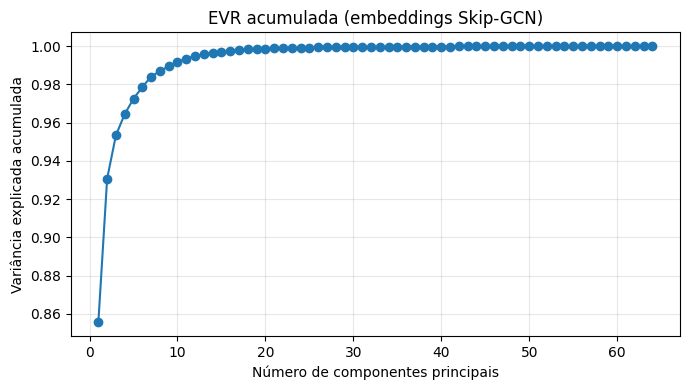

In [3]:
# ==========================================================
# EVR (variância explicada) vs nº de componentes (1..64) — Skip-GCN
# ==========================================================
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Caminho para o CSV de treino (ajusta ROOT/cfg se necessário)
emb_dir = (ROOT / cfg["paths"]["data_processed"] / "embeddings").resolve()
csv_train = emb_dir / "train_embeddings_skipgcn.csv"

# Carrega embeddings de treino (colunas emb_* e não emb_pca_*)
df = pd.read_csv(csv_train)
emb_cols = [c for c in df.columns if c.startswith("emb_") and not c.startswith("emb_pca_")]
X = df[emb_cols].values

# Padroniza e ajusta PCA até 64 PCs (ou até o nº de features)
X_std = StandardScaler().fit_transform(X)
n_comp = min(64, X_std.shape[1])
pca = PCA(n_components=n_comp, random_state=cfg.get("general", {}).get("seed", 42))
pca.fit(X_std)

evr_cum = np.cumsum(pca.explained_variance_ratio_)

# Plot único (sem salvar)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(range(1, n_comp + 1), evr_cum, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Variância explicada acumulada")
ax.set_title("EVR acumulada (embeddings Skip-GCN)")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()
